In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Activation, Reshape, Conv2DTranspose
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from google.colab import files, drive
from skimage.io import imread, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
import os
import io
import zipfile
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/tabOCR/'

Mounted at /content/gdrive


In [0]:
#uploaded = files.upload()
#data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_ann2.zip']), 'r')
#data.extractall()

In [0]:
input_height = 1024
input_width = 1024
n_classes = 51
batch_size = 2
loss = 'categorical_crossentropy'

In [0]:
# generator

In [0]:
class image_generator(Sequence):

    def __init__(self, image_filenames, mask_filenames, batch_size, img_size, n_calsses, loss='categorical_crossentropy', no_reshape=False):
        self.image_filenames, self.mask_filenames = image_filenames, mask_filenames
        self.batch_size = batch_size
        self.height = img_size[0]
        self.width = img_size[1]
        self.n_calsses = n_calsses
        self.no_reshape = no_reshape
        self.loss = loss

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def get_img_array(self, file_name):
      img = cv2.imread(file_name, 3)
      return cv2.resize(img, (self.height, self.width)).astype('float32')

    def get_segmentation_mask(self, file_name):
        img = cv2.imread(file_name, 1)
        img = cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_NEAREST)
        img = img[:, :, 0]
        seg_labels = np.zeros((self.width, self.height, self.n_calsses))
        for c in range(self.n_calsses):
          seg_labels[:, :, c] = (img == c).astype(int)
        if not self.no_reshape:
          seg_labels = np.reshape(seg_labels, (self.height*self.width, self.n_calsses))
        return seg_labels

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.loss == 'categorical_crossentropy':
           return (np.array([self.get_img_array(file_name) for file_name in batch_x]),
                   np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))
        else:
          return (np.array([self.get_img_array(file_name)for file_name in batch_x]),
                  np.array([self.get_segmentation_mask(file_name) for file_name in batch_y]))

In [0]:
# from drive
'''
image_filenames = []
mask_filenames = []
for path, _, files in os.walk(root_path + "table_imgs_train"):
    for f in files:
        imgs.append(os.path.join(path, f))
for path, _, files in os.walk(root_path + "table_mask_cell_train"):
    for f in files:
        masks.append(os.path.join(path, f))
train_generator = generator_disk(image_filenames, mask_filenames, batch_size=4, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
'''

# from uploaded
image_filenames = list(map(lambda s: "img_table/" + s, sorted(os.listdir('img_table'))))
mask_filenames = list(map(lambda s: "img_mask_cell/" + s, sorted(os.listdir('img_mask_cell'))))
image_filenames_val = list(map(lambda s: "img_table_val/" + s, sorted(os.listdir('img_table_val'))))
mask_filenames_val = list(map(lambda s: "img_mask_cell_val/" + s, sorted(os.listdir('img_mask_cell_val'))))
train_generator = image_generator(image_filenames, mask_filenames, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)
val_generator = image_generator(image_filenames_val, mask_filenames_val, batch_size=batch_size, img_size=(input_height, input_width), n_calsses=n_classes, loss=loss)

t = train_generator.__getitem__(0)
t[0].shape, t[1].shape

((2, 1024, 1024, 3), (2, 1048576, 51))

In [0]:
# model

In [0]:
# test 1
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
# conv5 = Conv2D(32, (3, 3), activation='softmax', padding='same')(conv5)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv5)
out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)

'''
# test 2
img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((4, 4))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.3)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)
up1 = concatenate([u3, conv2], axis=-1)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.3)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# pool3 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

u4 = Conv2DTranspose(32, (2, 2), strides=(4, 4), padding='same') (conv5)
up2 = concatenate([u4, conv1], axis=-1)

conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv6 = Dropout(0.1)(conv6)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

out = Conv2D(n_classes, (1, 1) , padding='same')(conv6)

out = Reshape((input_height*input_width, -1))(out)
out = Activation('softmax')(out)
'''





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




"\n# test1\nimg_input = Input(shape=(input_height,input_width , 3 ))\n\nconv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)\nconv1 = Dropout(0.2)(conv1)\nconv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)\npool1 = MaxPooling2D((4, 4))(conv1)\n\nconv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)\nconv2 = Dropout(0.2)(conv2)\nconv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)\npool2 = MaxPooling2D((2, 2))(conv2)\nconv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)\nconv3 = Dropout(0.3)(conv3)\nconv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)\n\nu3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv3)\nup1 = concatenate([u3, conv2], axis=-1)\n\nconv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)\nconv4 = Dropout(0.3)(conv4)\nconv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)\n# pool3 = MaxPooling2D((2, 2))(conv4)\nconv5 = Conv2

In [0]:
model = Model(img_input, out)
# model.compile(optimizer='adadelta', loss=loss,  metrics=['accuracy'])
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024, 1024, 3 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 1024, 3 9248        dropout_1[0][0]                  
__________________________________________________________________________________________

In [0]:
# fit generator
filepath = root_path + "outputs/weights_best_dominik_cell_1_adam.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max', period=1)
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10, verbose=1,
                               min_lr=0.1e-5)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto')
callbacks_list = [checkpoint, early_stopping, lr_reducer]

In [0]:
history = model.fit_generator(train_generator, validation_data=val_generator, epochs=10, steps_per_epoch=256, callbacks=callbacks_list, workers=2, use_multiprocessing=True, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





256/256 [==============================] - 7381s 29s/step - loss: 2.0338 - acc: 0.6475 - val_loss: 1.3076 - val_acc: 0.6667

Epoch 00001: acc improved from -inf to 0.64754, saving model to gdrive/My Drive/tabOCR/outputs/weights_best_test3_cell_adam.hdf5
Epoch 2/10
201/256 [======================>.......] - ETA: 30:27 - loss: 1.1938 - acc: 0.6811

Process ForkPoolWorker-45:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/proce

KeyboardInterrupt: ignored

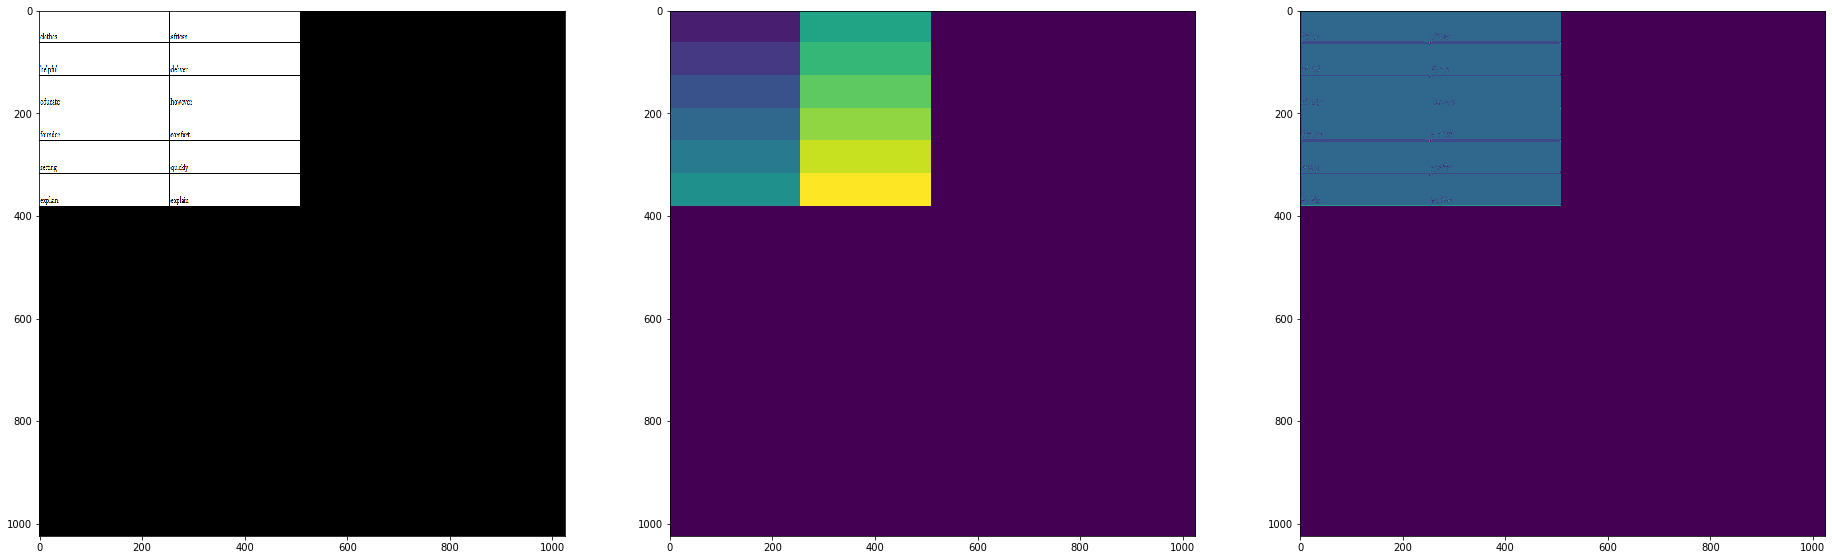

In [0]:
def predict(model, file_name_img, file_name_mask, input_height, input_width,
            n_classes):
    img_test = cv2.imread(file_name_img, 1)
    img_mask = cv2.imread(file_name_mask, 0)
    img_mask = cv2.resize(img_mask, (input_height, input_width),
                          interpolation=cv2.INTER_NEAREST)
    img_test = cv2.resize(img_test, (input_height, input_width),
                          interpolation=cv2.INTER_NEAREST)
    img_test = np.expand_dims(img_test, axis=0)
    mask_pred = model.predict(img_test)
    mask_pred = mask_pred.reshape((input_height, input_width, n_classes)).\
        argmax(axis=2)
    plt.figure(figsize=(32, 32))
    plt.subplot(1, 3, 1)
    plt.imshow(img_test[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred)
    plt.show()


predict(model, "img_table_val/54_table.png", "img_mask_cell_val/54_table.png", input_height, input_width, n_classes)